## Machine Leanring supervisé : prédire le score CVSS

### Data Understanding

In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
from pathlib import Path


# Chemins
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_CSV     = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Racine projet :", PROJECT_ROOT)
print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

# Chargement initial
df_full = (
    pd.read_csv(
        DATA_CSV,
        parse_dates=["date", "closed_at", "cve_pub"],
        keep_default_na=False
    )
    .replace({"n/a": np.nan, "": np.nan})
)

# Typage numérique + explosion versions
for col in ["cvss_score","epss_score","epss_percentile","lag_anssi_days","days_open", "n_revisions"]:
    if col in df_full: df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

# Vues à disposer
df_publi       = df_full.copy()                                             # toutes les lignes
df_clean       = df_full.dropna(subset=["cvss_score","epss_score"]).copy()  # pour scatter/violon…
df_unique_all  = (df_publi
                    .sort_values("date")
                    .drop_duplicates(subset=["cve"])
                    .copy())                                                   # pour cumuls, top vendors…
df_unique_scores = (df_clean
                      .sort_values("date")
                      .drop_duplicates(subset=["cve"])
                      .copy())                                                 # pour scatter unique,…

print("• df_publi       :", df_publi.shape)
print("• df_clean       :", df_clean.shape)
print("• df_unique_all  :", df_unique_all.shape)
print("• df_unique_scores:", df_unique_scores.shape)

📁 Racine projet : C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ
CSV présent : True - C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\data\processed\final_dataset.csv
• df_publi       : (264183, 22)
• df_clean       : (89424, 22)
• df_unique_all  : (38477, 22)
• df_unique_scores: (10797, 22)


### Analyse de corrélation des variables

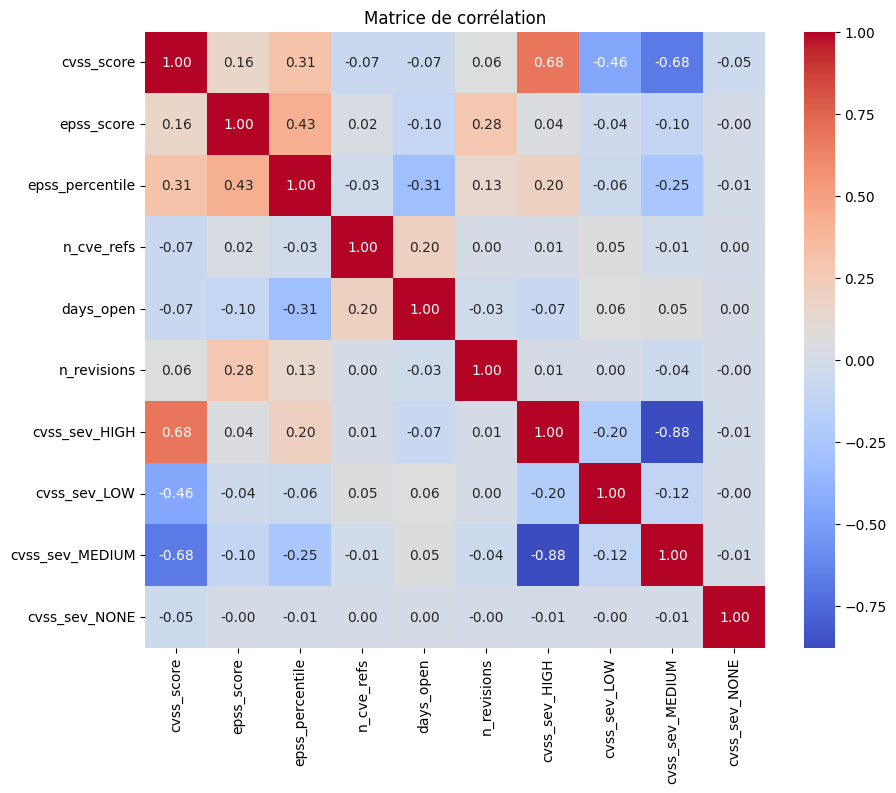

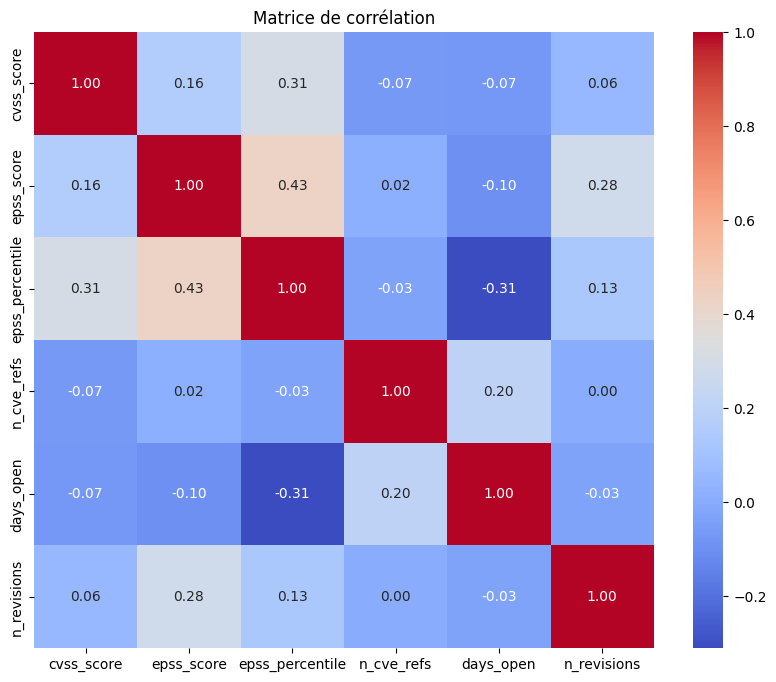

Nombre de valeurs NaN dans X : 0


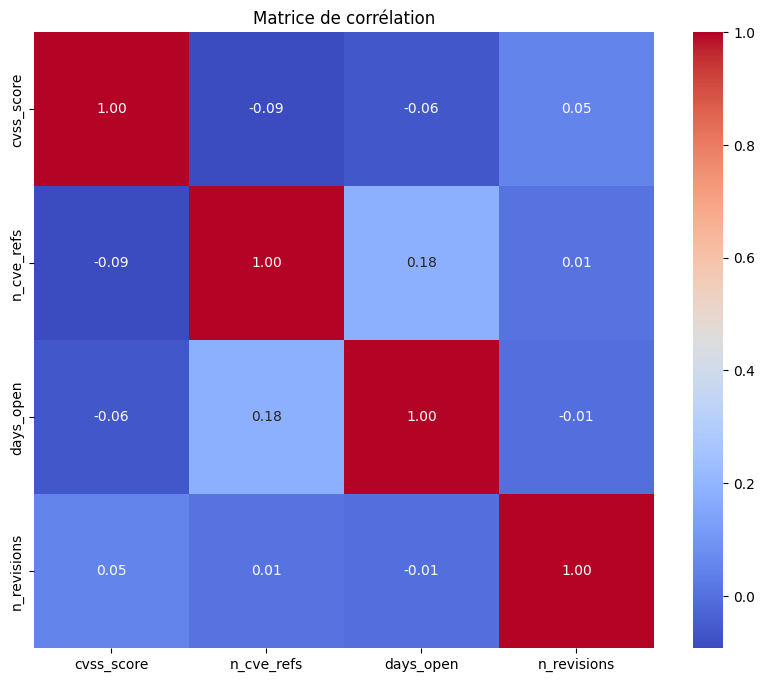

In [ ]:

#Sélection des colonnes pertinentes et fortement corrélées
data_heavy = df_full.dropna(subset=["cvss_score","cvss_sev", "epss_score", "epss_percentile","n_cve_refs","days_open", "n_revisions"]).copy()
data_heavy = data_heavy[["cvss_score", "cvss_sev", "epss_score", "epss_percentile", "n_cve_refs", "days_open", "n_revisions"]]
data_heavy = pd.get_dummies(data_heavy, drop_first=True)
# Calculer la matrice de corrélation
correlation_matrix = data_heavy.corr()

# Afficher la matrice de corrélation avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

#Sélection de colonnes pertinentes et moyennement corrélées
data_mid = df_full.dropna(subset=["cvss_score", "epss_score", "epss_percentile","n_cve_refs","days_open", "n_revisions"]).copy()
data_mid = data_mid[["cvss_score", "epss_score", "epss_percentile", "n_cve_refs", "days_open", "n_revisions"]]
data_mid = pd.get_dummies(data_mid, drop_first=True)
# Calculer la matrice de corrélation
correlation_matrix = data_mid.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

 # Supprimer les lignes avec des valeurs manquantes dans les colonnes nécessaires
X = df_full.dropna(subset=["cvss_score", "n_cve_refs","days_open", "n_revisions"]).copy()
# Garder uniquement les colonnes nécessaires
X = X[["cvss_score", "n_cve_refs", "days_open","n_revisions"]]
# Convertir les colonnes catégoriques en numériques
X = pd.get_dummies(X, drop_first=True)


correlation_matrix = X.corr()

# Afficher la matrice de corrélation avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,xticklabels=True, yticklabels=True, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

Dans la première matrice de corrélation, associant des variables censé être corrélés au score CVSS, on observe assez logiquement que des variables comme le score EPSS et le pourcentage EPSS sont fortement corrélées entre elles (proche de 1 ou -1), et que les sévérité CVSS sont corrélés avec le score CVSS. 

Dans la deuxième, éliminant la sévérité CVSS, on remarque plus facilement que le nombre de jours d'ouverture d'un bulletin est corrélé avec le pourcentage EPSS.

Finalement, la dernière matrice de corrélation regroupe les variables les moins corrélées entre elles. C'est ces variables que nous utiliserons pour prédire le score CVSS d'un bulletin. Nous allons également associés les variables des éditeurs pour affiner notre modèle.

### Data preprocessing

Choix des données input (X) et target (y), Sampling, One Hot encoding

Counter({'HIGH': 8153, 'MEDIUM': 4452, 'CRITICAL': 537, 'LOW': 336})


C:\Users\thoma\AppData\Local\Temp\ipykernel_11664\1476919252.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis', hue=None)


<Axes: xlabel='cvss_score', ylabel='count'>

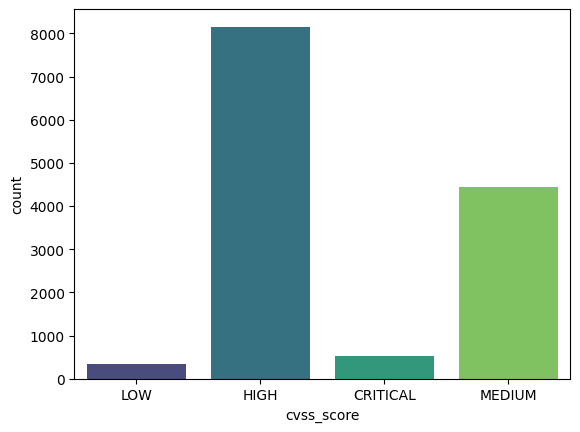

In [ ]:
# Sélection un échantillon du DataFrame complet pour l'entraînement
df_sample = df_full.sample(frac=0.1, random_state=42)

# Supprimer les lignes avec des valeurs manquantes dans les colonnes nécessaires
X = df_sample.dropna(subset=["cvss_score", "n_cve_refs","days_open", "vendor", "n_revisions"]).copy()

# Garder uniquement les colonnes nécessaires
X = X[["cvss_score", "n_cve_refs", "days_open", "vendor", "n_revisions"]]

# Définir la cible (y) en classes discrètes
def map_cvss_to_class(score):
    if score < 4.0:
        return "LOW"
    elif 4.0 <= score < 7.0:
        return "MEDIUM"
    elif 7.0 <= score < 9.0:
        return "HIGH"
    else:
        return "CRITICAL"

y = X["cvss_score"].apply(map_cvss_to_class)
X = X.drop(columns=["cvss_score"])

# One Hot Encoding, convertir les colonnes catégoriques en numériques
X = pd.get_dummies(X, drop_first=True)

# Visualiser la distribution des classes
print(Counter(y))
sns.countplot(x=y, palette='viridis', hue=None)

### Equilibrage des données avec SMOTE

Counter({'LOW': 8153, 'HIGH': 8153, 'CRITICAL': 8153, 'MEDIUM': 8153})


C:\Users\thoma\AppData\Local\Temp\ipykernel_11664\2288937934.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_b, palette='viridis', hue=None)


<Axes: xlabel='cvss_score', ylabel='count'>

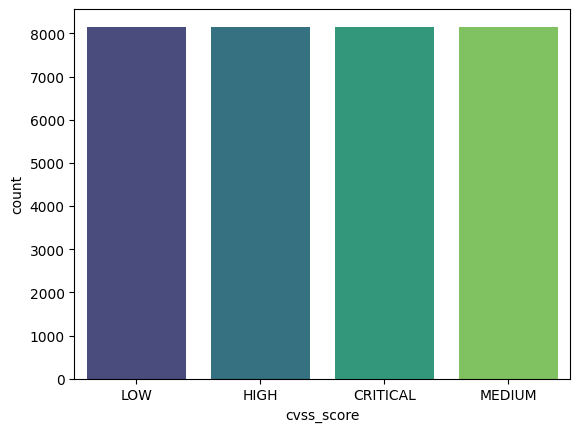

In [83]:
# Appliquer SMOTE pour équilibrer les classes
X_b, y_b = SMOTE().fit_resample(X, y)

# Visualiser la distribution des classes
print(Counter(y_b))
sns.countplot(x=y_b, palette='viridis', hue=None)

### Modèle **1** : Random Forest

Splitting des données de test et train préalable

Accuracy: 65.215.
Precision: 0.652.
Recall: 0.652.
F1 Score: 0.652.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.68      0.63      0.65      1681
        HIGH       0.54      0.75      0.63      1620
         LOW       0.77      0.83      0.80      1616
      MEDIUM       0.67      0.40      0.50      1606

    accuracy                           0.65      6523
   macro avg       0.66      0.65      0.64      6523
weighted avg       0.66      0.65      0.64      6523



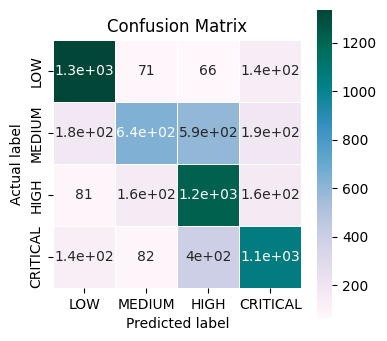

In [84]:
# Diviser les données en ensembles d'entraînement et de test
X_tr, X_te, y_tr, y_te = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

rf_b = RandomForestClassifier(random_state=42)
rf_b.fit(X_tr, y_tr)
y_pred_b = rf_b.predict(X_te)

# Fonction pour évaluer le modèle
def evaluate_model(y_true, y_pred, labels=["LOW", "MEDIUM", "HIGH", "CRITICAL"]):
    # Évaluer les performances
    acc = accuracy_score(y_true, y_pred) * 100
    pre = precision_score(y_true, y_pred, average='micro')
    rec = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')

    print("Accuracy: {:.3f}.".format(acc))
    print("Precision: {:.3f}.".format(pre))
    print("Recall: {:.3f}.".format(rec))
    print("F1 Score: {:.3f}.".format(f1))

    print("\nClassification Report")
    print(classification_report(y_true, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, linewidths=.5, square=True, cmap='PuBuGn', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title("Confusion Matrix", size=12)
    plt.show()
    

# Appeler la fonction avec les labels mis à jour
evaluate_model(y_te, y_pred_b)

### Analyse des variables les plus significatives

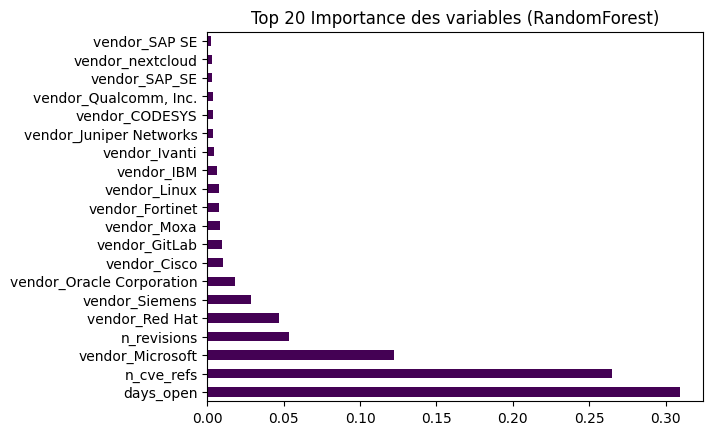

In [85]:
feature_importances = pd.Series(rf_b.feature_importances_, index=X.columns)
top_20_features = feature_importances.sort_values(ascending=False).head(20)
top_20_features.plot(kind='barh', colormap='viridis')
plt.title("Top 20 Importance des variables (RandomForest)")
plt.show()

### Hyperparameter Tuning : Random Forest

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 300, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}
Best score is 0.644315141816359
Accuracy: 65.384.
Precision: 0.654.
Recall: 0.654.
F1 Score: 0.654.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.68      0.63      0.65      1681
        HIGH       0.54      0.74      0.62      1620
         LOW       0.77      0.83      0.80      1616
      MEDIUM       0.68      0.41      0.51      1606

    accuracy                           0.65      6523
   macro avg       0.66      0.65      0.65      6523
weighted avg       0.66      0.65      0.65      6523



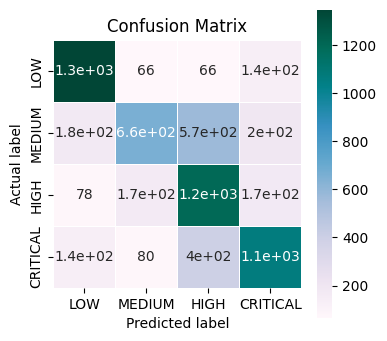

In [ ]:
rf_clf_cv = RandomForestClassifier(random_state=2002)

scoring_strategy = 'f1_macro' 

param_grid = {
    'n_estimators': [1000, 2000],  # Nombre d'arbres dans la forêt
    'max_depth': [200, 300],  # Profondeur maximale des arbres
    'min_samples_split': [5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2,],     # Nombre minimum d'échantillons requis pour être à une feuille
    'max_features': ['log2', 'sqrt'],   # Nombre de caractéristiques à considérer lors de la recherche de la meilleure séparation
    'criterion': ['gini']  # Critère de qualité de la séparation
}

rf_clf_cv = GridSearchCV(rf_clf_cv, param_grid, cv=4, n_jobs=6, verbose=1, scoring=scoring_strategy)
rf_clf_cv.fit(X_tr, y_tr)

print("Tuned Random Forest Parameters: {}".format(rf_clf_cv.best_params_))
print("Best score is {}".format(rf_clf_cv.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = rf_clf_cv.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Modèle **2** : KNN (K-Nearest Neighbors)

Accuracy: 60.662.
Precision: 0.607.
Recall: 0.607.
F1 Score: 0.607.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.69      0.51      0.59      1681
        HIGH       0.52      0.70      0.59      1620
         LOW       0.64      0.83      0.72      1616
      MEDIUM       0.63      0.39      0.48      1606

    accuracy                           0.61      6523
   macro avg       0.62      0.61      0.60      6523
weighted avg       0.62      0.61      0.60      6523



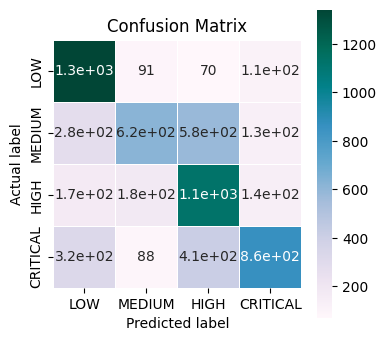

In [105]:
from sklearn.neighbors import KNeighborsClassifier

knn_b = KNeighborsClassifier(n_neighbors=5)
knn_b.fit(X_tr, y_tr)
y_pred_knn_b = knn_b.predict(X_te)

# Évaluer le modèle KNN
evaluate_model(y_te, y_pred_knn_b)

### Hyperparameter Tuning : KNN

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Tuned KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score is 0.6182025744950168
Accuracy: 63.422.
Precision: 0.634.
Recall: 0.634.
F1 Score: 0.634.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.68      0.58      0.63      1681
        HIGH       0.51      0.79      0.62      1620
         LOW       0.75      0.80      0.78      1616
      MEDIUM       0.67      0.36      0.47      1606

    accuracy                           0.63      6523
   macro avg       0.65      0.63      0.62      6523
weighted avg       0.65      0.63      0.62      6523



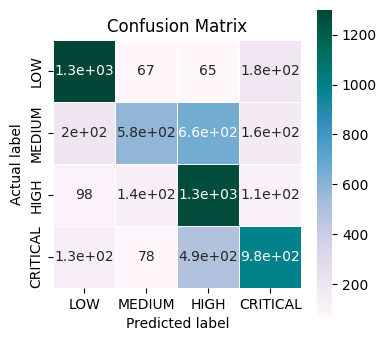

In [108]:
#HP Tunning
knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': [7, 9, 11, 14],  # Nombre de voisins à considérer
    'weights': ['uniform', 'distance'],  # Poids des voisins
    'metric': ['euclidean', 'manhattan']  # Métriques de distance
}

knn_grid = GridSearchCV(estimator = knn, param_grid = parameters, cv = 4, n_jobs = 6, verbose = 1, scoring=scoring_strategy)
knn_grid.fit(X_tr, y_tr)

print("Tuned KNN Parameters: {}".format(knn_grid.best_params_))
print("Best score is {}".format(knn_grid.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = knn_grid.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Modèle **3** : LR (Logistic Regression)

c:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 53.380.
Precision: 0.534.
Recall: 0.534.
F1 Score: 0.534.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.64      0.29      0.40      1681
        HIGH       0.48      0.74      0.58      1620
         LOW       0.52      0.88      0.66      1616
      MEDIUM       0.68      0.23      0.34      1606

    accuracy                           0.53      6523
   macro avg       0.58      0.54      0.50      6523
weighted avg       0.58      0.53      0.49      6523



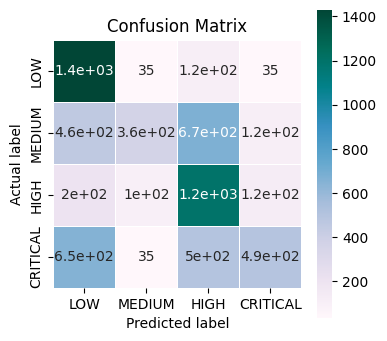

In [109]:
from sklearn.linear_model import LogisticRegression

lr_b = LogisticRegression(max_iter=5000)
lr_b.fit(X_tr, y_tr)
y_pred_lr_b = lr_b.predict(X_te)

# Évaluer le modèle de régression logistique
evaluate_model(y_te, y_pred_lr_b)

### Hyperparameter Tuning : Logistic Regression

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Tuned KNN Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best score is 0.4970124038588042
Accuracy: 63.422.
Precision: 0.634.
Recall: 0.634.
F1 Score: 0.634.

Classification Report
              precision    recall  f1-score   support

    CRITICAL       0.68      0.58      0.63      1681
        HIGH       0.51      0.79      0.62      1620
         LOW       0.75      0.80      0.78      1616
      MEDIUM       0.67      0.36      0.47      1606

    accuracy                           0.63      6523
   macro avg       0.65      0.63      0.62      6523
weighted avg       0.65      0.63      0.62      6523



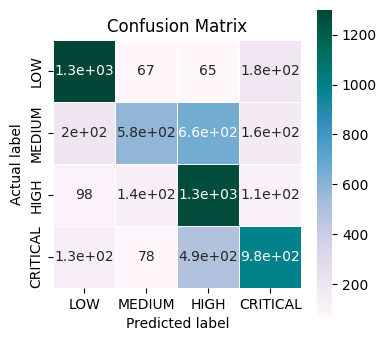

In [110]:
# LR HP Tunning
log_reg = LogisticRegression(max_iter=5000)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Inverse de la régularisation
    'penalty': ['l2'],  # Type de pénalité
    'solver': ['lbfgs', 'liblinear'],  # Algorithme d'optimisation
    'class_weight': [None, 'balanced']  # Poids des classes    
}

log_reg_cv = GridSearchCV(log_reg, param_grid, cv=4, n_jobs = 6, verbose = 1, scoring=scoring_strategy)
log_reg_cv.fit(X_tr, y_tr)

print("Tuned KNN Parameters: {}".format(log_reg_cv.best_params_))
print("Best score is {}".format(log_reg_cv.best_score_))

# Évaluation du modèle optimisé
y_pred_cv = knn_grid.predict(X_te)
# Appeler la fonction d'évaluation avec les labels mis à jour
evaluate_model(y_te, y_pred_cv)

### Conclusion : 

Nous observons que le modèle le plus performant pour prédire la sévérité CVSS est la méthode Random Forest, atteignant un F1 score de **0.65** contre 0.63 pour les autres modèles.